# AE를 이용한 이상치검출

## 1. 라이브러리 임포트

In [1]:
#텐서플로, numpy, matplotlib의 라이브러리 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#MNIST 모듈 임포트
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0808 19:51:04.701666 140673295595264 deprecation.py:323] From <ipython-input-1-e31785d46748>:8: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0808 19:51:04.702940 140673295595264 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0808 19:51:04.703935 140673295595264 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0808 19:51:04.917604 140673295595264 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2. Mnist train/test 분류
Mnist는 원래 2가지 파일로 구성되어 있음 
  1. mnist.train : 0~9까지 60,000개 이미지 
  2. mnist.test  : 0~9까지 10,000개 이미지 

### 테스트 이미지 파일 생성
1. mnist.train에서 trian 파일 생성, 1~9의 숫자 그림으로 구성 
2. mnist.test에서 test 파일 생성, 0만을 두어 학습된 데이터에서 다른 값(0)이 들어갔을 경우 cost값을 확인하여 이상치를 검출할 수 있다.

In [2]:
# np.argmax : 배열중에 가장 큰 수를 뽑아냄, labels에서 숫자 확인 가능
# 예시) lables가 [0,0,1,0,0,0,0,0,0,0] 이면 2로 값이 나오게 됨
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 2) | \
             (np.argmax(mnist.train.labels, 1) == 3) | \
             (np.argmax(mnist.train.labels, 1) == 4) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6) | \
             (np.argmax(mnist.train.labels, 1) == 7) | \
             (np.argmax(mnist.train.labels, 1) == 8) | \
             (np.argmax(mnist.train.labels, 1) == 9))
test_idx = (np.argmax(mnist.test.labels, 1) == 0)

train_imgs   = mnist.train.images[train_idx] # 1~9까지 train 이미지 추출
train_labels = mnist.train.labels[train_idx] # 1~9까지 train 라벨 추출
test_imgs    = mnist.test.images[test_idx] # 0만 test 이미지 추출
test_labels  = mnist.test.labels[test_idx] # 0만 test 라벨 추출
n_train      = train_imgs.shape[0] # train 이미지 shape 변경
n_test       = test_imgs.shape[0] # test 이미지 shape 변경

print ("The number of training images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_imgs.shape))

The number of training images : 49556, shape : (49556, 784)
The number of testing images : 980, shape : (980, 784)


## 3. 옵션설정

In [3]:
learning_rate = 0.01 #최적화 함수에서 사용할 학습률
training_epoch = 20  #전체 데이터를 학습할 총 횟수
batch_size = 100     #미니배치로 한번에 학습할 데이터(이미지)의 갯수
n_hidden = 256       #은닉층의 뉴런 개수
n_input = 28*28      #이미지 크기 28*28 = 784

## 4. 모델구성

In [4]:
# X라는 플레이스 홀더를 설정
X = tf.placeholder(tf.float32, [None, n_input])

# ENCODER 인코더, n_hidden개의 뉴런을 가진 은닉층 만듬
W_encode = tf.Variable(tf.random_normal([n_input, n_hidden]))  #n_hidden개의 뉴런을 가진 은닉층 만듬
b_encode = tf.Variable(tf.random_normal([n_hidden])) 
encoder = tf.nn.sigmoid(tf.add(tf.matmul(X,W_encode),b_encode)) #sigmoid 활성화 함수 적용

# DECODER 디코더 (n_input과 n_hidden을 인코더와 반대로 입력)
W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))
decoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder,W_decode),b_decode))

## 5. 모델학습
### 손실함수
가중치들을 최정화하기 위해, 출력값과 입력값이 가장 비슷하게 만들어 입력값의 특징을 알 수 있도록 함

\begin{align}
\frac{1}{m}\sum_i^m{(t_i-y_i)}^2
\end{align}

In [5]:
#손실함수(두 값의 거리차이) = X(평가하기 위한 실측값) - 디코더의 결과값
cost = tf.reduce_mean(tf.pow(X-decoder,2))

#최적화 함수 RMSPropOptimizer로 cost를 최소화 함
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

#train에 해당하는 그림만을 가지고 batch할 수 있는 함수 생성
def train_batch_maker(batch_size):
     random_idx = np.random.randint(n_train, size = batch_size)
     return train_imgs[random_idx], train_labels[random_idx]

#학습진행
init = tf.global_variables_initializer() #변수 초기화
sess = tf.Session() # Session 오픈
sess.run(init) # 텐서플로우로 변수들 초기화 완료(학습 진행 준비 완료)

total_batch = int(n_train/batch_size) #배치 변수

for epoch in range(training_epoch): 
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = train_batch_maker(batch_size)
        _, cost_val = sess.run([optimizer, cost], feed_dict={X:batch_xs})
        total_cost += cost_val
        
    print('Epoct:', '%04d' % (epoch + 1), 'Avg. cost = ', '{:.4f}'.format(total_cost/total_batch))

print('최적화 완료!')


W0808 19:51:17.989464 140673295595264 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0808 19:51:18.027757 140673295595264 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoct: 0001 Avg. cost =  0.1983
Epoct: 0002 Avg. cost =  0.0575
Epoct: 0003 Avg. cost =  0.0472
Epoct: 0004 Avg. cost =  0.0415
Epoct: 0005 Avg. cost =  0.0387
Epoct: 0006 Avg. cost =  0.0366
Epoct: 0007 Avg. cost =  0.0342
Epoct: 0008 Avg. cost =  0.0331
Epoct: 0009 Avg. cost =  0.0324
Epoct: 0010 Avg. cost =  0.0319
Epoct: 0011 Avg. cost =  0.0314
Epoct: 0012 Avg. cost =  0.0297
Epoct: 0013 Avg. cost =  0.0292
Epoct: 0014 Avg. cost =  0.0288
Epoct: 0015 Avg. cost =  0.0284
Epoct: 0016 Avg. cost =  0.0281
Epoct: 0017 Avg. cost =  0.0278
Epoct: 0018 Avg. cost =  0.0277
Epoct: 0019 Avg. cost =  0.0275
Epoct: 0020 Avg. cost =  0.0272
최적화 완료!


## 6.1 Traing data 결과확인

Training data cost =  0.0260


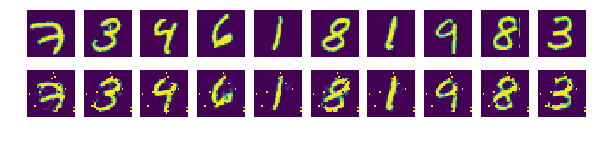

In [6]:
sample_size = 10 #샘플로 볼 이미지 갯수 지정

# 텐서플로우로 train이미지(1~9)까지 DECODER로 학습진행
samples = sess.run(decoder, feed_dict={X:train_imgs[:sample_size]}) 
print('Training data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:train_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(train_imgs[i], (28,28)))
    ax[1][i].imshow(np.reshape(samples[i], (28,28)))

plt.show()

## 6.2 Testing data 결과확인

Testing data cost =  0.0383


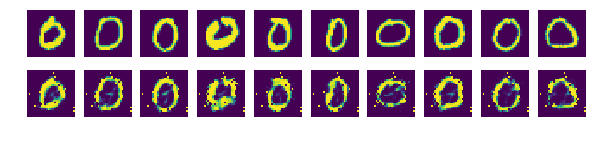

In [7]:
sample_size = 10 #샘플로 볼 이미지 갯수 지정

# 텐서플로우로 test이미지(0만)까지 DECODER로 학습진행
ADsamples = sess.run(decoder, feed_dict={X:test_imgs[:sample_size]})
print('Testing data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:test_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(test_imgs[i], (28,28))) 
    ax[1][i].imshow(np.reshape(ADsamples[i], (28,28)))

plt.show()

# 7. Confusion Matrix(오차행렬)
### 참이라고 간주되는 관측값과 평가를 위해 추출된 샘플간의 비교를 위한 행렬
### 참고 : https://en.wikipedia.org/wiki/Confusion_matrix
### 참고 : https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

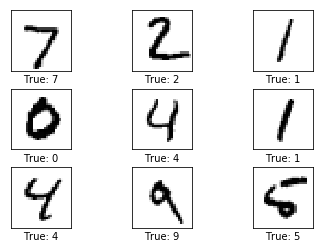

In [8]:
#예시 이미지 보여줃수 있는 함수를 만듭니다.
def plot_images(images, cls_true, cost=None):

    # 3*3의 행렬로 보여줄 수 있도록 
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 이미지 보여주는 함수
        ax.imshow(images[i].reshape(28,28), cmap='binary')

        # cost값이 있으면 cost값까지 같이 보여줄 수 있도록 함
        if cost is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Cost: {1:0.4f}".format(cls_true[i], cost[i])

        ax.set_xlabel(xlabel)
        
        # 각 그림 표의 범주를 없앤다(그림으로 보여주기위해)
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

images = mnist.test.images[0:9] #test 데이터 (0~9까지 있는 test 데이터)
cls_true = np.argmax(mnist.test.labels[0:9], axis=1) #test데이터의 label값불러오기(각 그림이 어떤 숫자인지 라벨값이 매겨져 있음)
plot_images(images=images, cls_true=cls_true) #이미지 보여주는 함수

## 1) 각 그림 별 손실함수(Cost) 구하기

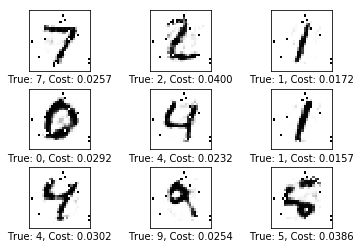

In [9]:
sample_size=10 #샘플 이미지 갯수

sample_cost=[] #smaple_cost list 초기화
for i in range (sample_size): #각 그림별로 cost 값 계산하여 sample_cost라는 list 생성
    ind_cost = tf.reduce_mean(tf.pow(X[i]-decoder[i],2)) #손실함수 공식
    sample_cost.append(ind_cost)

def IndCost(): #개별 cost별로 위의 이미지 형식에 맞게 보여주기 위한 함수를 만듭니다.
    ind_cost = sess.run(sample_cost, feed_dict={X:mnist.test.images})
    samples = sess.run(decoder, feed_dict={X:mnist.test.images})

    plot_images(images=samples[0:9], # 복원된 그림 이미지
                cls_true=cls_true[0:9], # 각 이미지 별 라벨값
                cost=ind_cost[0:9]) # 각 이미지 별 Cost 값

IndCost() #함수 실행

## 2) 실제값(y_true) 구하기
### 이미지별 라벨값이 0이면 Anomal인 0의 값, 라벨값이 1~9면 nomal인 1의 값을 입력 (AE 통과 할 필요 없음)

In [11]:
all_size = len(mnist.test.labels) #테스트 데이터 갯수는 10000개 

y_true = [] #y_true list 초기화 

for i in range(all_size):
    if np.argmax(mnist.test.labels[i]) == 0:
        y_true.insert(i, 0) #라벨값이 0이면 Anomal
    else:
        y_true.insert(i, 1) #라벨값이 0이 아니면 nomal (1~9까지는 1로)

print(y_true) #프린트로 값을 확인할 수 있다.

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 

## 3) 예측값(y_pred) 구하기

### cost의 측정지표(통계값)

In [13]:
import pandas as pd #판다스 라이브러리 임포트

all_cost=[] #all_cost라는 전체 테스트 데이터의 각 그림별 cost에 대한 list 초기화
for i in range (all_size):
    ind_cost = tf.reduce_mean(tf.pow(X[i]-decoder[i],2))
    all_cost.append(ind_cost)

def median(): #통계지표 구하는 함수 생성
    ind_cost = sess.run(all_cost, feed_dict={X:mnist.test.images}) #Cost값 계산하기
    
    median = np.median(ind_cost) #중앙값 구하는 함수
    print('median :', '{:.4f}'.format(median))    
    
    print('\n')
    print('Cost Metric')
    cost_df = pd.DataFrame({'Cost':ind_cost}) #기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 함수
    print(cost_df.describe())
    
    print('\n')
    plt.title('Cost Histogram')
    plt.hist(ind_cost, bins=10) #히스토그램 함수, bins:데이터를 범주화 하는 기준
    plt.show()

In [ ]:
median() #함수 실행 

### cost의 중앙값(median)을 임계점으로 설정, 각 그림별 Cost가 임계점보다 높으면 positive(이상), 낮으면 negative(정상)

In [12]:
# 각 이미지별 cost를 구하여 중앙값을 구한다. (자세한 방식은 아래 참고)
ind_cost = sess.run(all_cost, feed_dict={X:mnist.test.images})
median = np.median(ind_cost)

y_pred = [] #y_pred list 초기화
for i in range(all_size):
    if ind_cost[i] > median:
        y_pred.insert(i, 0) #임계점보다 높으면 positive(이상)
    else:
        y_pred.insert(i, 1) #임계점보다 낮으면 negative(정상)
        
print(y_pred) #프린트로 값을 확인할 수 있다.

NameError: name 'all_cost' is not defined

## 4) Confusion_matrix 계산하기


 TP : 883 
 FN : 97 
 FP : 4117 
 TN : 4903 

Accuracy(정분류율): 0.5786
Error_rate(오분류율): 0.4214
Precirion(정확도): 0.1766
Recall(재현율, 민감도): 0.9010




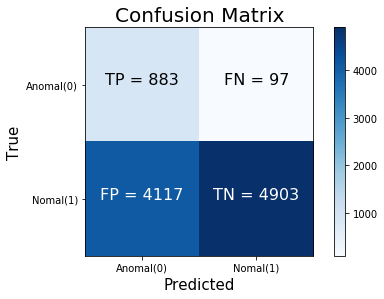

In [46]:
cm = tf.confusion_matrix(y_true, y_pred) #confusion_matrix 함수 실행
con_mat = sess.run(cm) #텐서플로우 실행 후 con_mat으로 입력
    
# Print the confusion matrix as text.
TP = con_mat[0][0] #둘다 Anomal, 0이며 예측값이 positive(이상값)이다.
FN = con_mat[0][1] #실제값과 예측값이 달랐으며, 예측값이 negative(정상값)이다.
FP = con_mat[1][0] #실제값과 예측값이 달랐으며, 예측값이 postive(이상값)이다.
TN = con_mat[1][1] #둘다 nomal, 1이며 예측값이 negative(정상값)이다.
print('\n',
      'TP :', TP, '\n', 
      'FN :', FN, '\n', 
      'FP :', FP, '\n', 
      'TN :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN) #정분류율 : 전체관측치 중 실제값과 예측치가 일치하는 정도
print('Accuracy(정분류율):', '{:.4f}'.format(Accuracy))

Error_rate = (FP+FN)/(TP+FN+FP+TN) #오분류율 : 전체 관측치 중 실제값과 예측치가 다른 정보 (1-accuracy)
print('Error_rate(오분류율):', '{:.4f}'.format(Error_rate))

Precirion = TP/(TP+FP) #정확도 : TRUE로 예측한 관측치 중 실제값이 TRUE인 정도
print('Precirion(정확도):', '{:.4f}'.format(Precirion))

Recall = TP/(TP+FN) #재현율 : 실제값이 TRUE인 관측치 중 예측치가 적중한 정도, 모형의 완정성을 평가함, 민감도
print('Recall(재현율, 민감도):', '{:.4f}'.format(Recall))

print('\n')
# Confusion Matrix 표 그리기
plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)
# Plot 구성하기
plt.title('Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.colorbar()
label=["Anomal(0)", "Nomal(1)"]
tick_marks = np.arange(len(label))
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
    
plt.show()